In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install tree_sitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tree_sitter: filename=tree_sitter-0.20.1-cp310-cp310-linux_x86_64.whl size=434939 sha256=aa9d7cb9c3d9e8135583b16a4066260bf75a0b525865e9eb9308b2c1f2ac5631
  Stored in directory: /root/.cache/pip/wheels/e6/d0/7a/a108b30f6615a71ca3a07ced1b149509d437a60c9d64820723
Successfully built tree_sitter


In [3]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab_Notebooks/SyntaxSwap_model/ml_model/graphcodebert/model3-modified')
#sys.path.insert(0, '/content/drive/MyDrive/IIT/Final Year/Final Year Project/code/SyntaxSwap_model/ml_model/graphcodebert/model3')
# sys.path.insert(0, '/content/drive/Othercomputers/My Laptop/IIT/Final Year/Final Year Project/code/SyntaxSwap_model/ml_model/graphcodebert/model3')

In [4]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Fine-tuning the library models for language modeling on a text file (GPT, GPT-2, BERT, RoBERTa).
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss while BERT and RoBERTa are fine-tuned
using a masked language modeling (MLM) loss.
"""

from __future__ import absolute_import
import os
import sys
import pickle
import torch
import json
import random
# import logging
import argparse
import numpy as np
from io import open
from itertools import cycle
import torch.nn as nn

#from model import Seq2Seq
# from original_model import Seq2Seq
from model2 import Seq2Seq

import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from bleu import _bleu
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from torch.utils.data.distributed import DistributedSampler
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaModel, RobertaTokenizer)
MODEL_CLASSES = {'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer)}

# logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
#                     datefmt = '%m/%d/%Y %H:%M:%S',
#                     level = logging.INFO)

In [5]:
from DFG import (
    DFG_java,
    DFG_javascript
)
from utils import (
    remove_comments_and_docstrings,
    tree_to_token_index,
    index_to_code_token, 
    tree_to_variable_index
)
from tree_sitter import Language, Parser


In [6]:
dfg_function={
    'java':DFG_java,
    'javascript':DFG_javascript
}

In [7]:
!cd drive/MyDrive/Colab_Notebooks/SyntaxSwap_model/ml_model/graphcodebert/model3/build_parser


In [8]:
language_path = '/content/drive/MyDrive/Colab_Notebooks/SyntaxSwap_model/ml_model/graphcodebert/model3-modified/build_parser/my-languages.so'
#language_path = '/content/drive/MyDrive/IIT/Final Year/Final Year Project/code/SyntaxSwap_model/ml_model/graphcodebert/model3/build_parser/my-languages.so'

In [9]:

# # logger = logging.getLogger(__name__)
# !cp '/content/drive/MyDrive/Colab_Notebooks/SyntaxSwap_model/ml_model/graphcodebert/model3/build_parser/java_js.so'
# language_path = '/content/drive/MyDrive/Colab_Notebooks/SyntaxSwap_model/ml_model/graphcodebert/model3/build_parser/java_js.so'

# import ctypes
# lang_lib = ctypes.CDLL(language_path)

In [10]:

#load parsers
parsers={}        
for lang in dfg_function:
    print("lang",lang)
    LANGUAGE = Language(language_path, lang)
    parser = Parser()
    parser.set_language(LANGUAGE) 
    parser = [parser,dfg_function[lang]]    
    parsers[lang]= parser
    
print("Parsers :",parsers)

lang java
lang javascript
Parsers : {'java': [<tree_sitter.Parser object at 0x7fba31bccdb0>, <function DFG_java at 0x7fbaf34e0dc0>], 'javascript': [<tree_sitter.Parser object at 0x7fba31bccd10>, <function DFG_javascript at 0x7fba31c0ed40>]}


In [11]:
#remove comments, tokenize code and extract dataflow     
def extract_dataflow(code, parser,lang):
    #remove comments
    try:
        code=remove_comments_and_docstrings(code,lang)
    except:
        pass       
    try:
        tree = parser[0].parse(bytes(code,'utf8'))    
        root_node = tree.root_node  
        tokens_index=tree_to_token_index(root_node)     
        code=code.split('\n')
        code_tokens=[index_to_code_token(x,code) for x in tokens_index]  
        index_to_code={}
        for idx,(index,code) in enumerate(zip(tokens_index,code_tokens)):
            index_to_code[index]=(idx,code)  
        try:
            DFG,_=parser[1](root_node,index_to_code,{}) 
        except:
            DFG=[]
        DFG=sorted(DFG,key=lambda x:x[1])
        indexs=set()
        for d in DFG:
            if len(d[-1])!=0:
                indexs.add(d[1])
            for x in d[-1]:
                indexs.add(x)
        new_DFG=[]
        for d in DFG:
            if d[1] in indexs:
                new_DFG.append(d)
        dfg=new_DFG
    except:
        dfg=[]
    return code_tokens,dfg



In [12]:
class Example(object):
    """A single training/test example."""
    def __init__(self,
                 source,
                 target,
                 lang
                 ):
        self.source = source
        self.target = target
        self.lang=lang


def read_examples(source_file='source.txt', target_file='target.txt'):
    """Read examples from filename."""
    examples=[]
    source = source_file
    target = target_file
        
    with open(source,encoding="utf-8") as f1,open(target,encoding="utf-8") as f2:
        for line1,line2 in zip(f1,f2):
            line1=line1.strip()
            line2=line2.strip()
            examples.append(
                Example(
                    source=line1,
                    target=line2,
                    lang=lang
                        ) 
            )

    return examples

class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 example_id,
                 source_ids,
                 position_idx,
                 dfg_to_code,
                 dfg_to_dfg,                 
                 target_ids,
                 source_mask,
                 target_mask,

    ):
        self.example_id = example_id
        self.source_ids = source_ids
        self.position_idx = position_idx
        self.dfg_to_code = dfg_to_code
        self.dfg_to_dfg = dfg_to_dfg
        self.target_ids = target_ids
        self.source_mask = source_mask
        self.target_mask = target_mask  


In [13]:
# parsers={}        
# for lang in dfg_function:
#     LANGUAGE = Language('build_parser/java_js.so', lang)
#     parser = Parser()
#     parser.set_language(LANGUAGE) 
#     parser = [parser,dfg_function[lang]]    
#     parsers[lang]= parser

In [14]:
max_source_length = 320
max_target_length = 256
source_lang = "java"
target_lang = "javascript"

def convert_examples_to_features(examples, tokenizer, stage=None):
    features = []
    for example_index, example in enumerate(tqdm(examples,total=len(examples))):
        ##extract data flow
        code_tokens,dfg=extract_dataflow(example.source,
                                         parsers["java"],
                                         "java")
        code_tokens=[tokenizer.tokenize('@ '+x)[1:] if idx!=0 else tokenizer.tokenize(x) for idx,x in enumerate(code_tokens)]
        # ORIGINAL TO CURRENT TOKEN POSITION
        ori2cur_pos={}
        ori2cur_pos[-1]=(0,0)
        for i in range(len(code_tokens)):
            ori2cur_pos[i]=(ori2cur_pos[i-1][1],ori2cur_pos[i-1][1]+len(code_tokens[i]))    
        code_tokens=[y for x in code_tokens for y in x]  
        
        #truncating
        code_tokens=code_tokens[:max_source_length-3][:512-3]
        
        # Adds the special tokens [CLS] and [SEP] to the beginning and end of the token 
        source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
        # convert the tokens to their corresponding token ids
        source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)

        position_idx = [i+tokenizer.pad_token_id + 1 for i in range(len(source_tokens))]
        dfg=dfg[:max_source_length-len(source_tokens)]
        """
        Concatenates the dfg edge labels with the source_tokens list and adds a 0 to the
        position_idx list for each dfg edge label.

        """
        source_tokens+=[x[0] for x in dfg]
        """
        Sets the token ids for the dfg edge labels to tokenizer.unk_token_id, indicating 
        that they are unknown tokens.
        """
        position_idx+=[0 for x in dfg]
        source_ids+=[tokenizer.unk_token_id for x in dfg]
        """
        Pads the position_idx and source_ids lists with tokenizer.pad_token_id to ensure 
        that they have the same length as max_source_length.
        """
        padding_length=max_source_length-len(source_ids)
        position_idx+=[tokenizer.pad_token_id]*padding_length
        source_ids+=[tokenizer.pad_token_id]*padding_length  

        """
        Creates a source_mask list that indicates which tokens in the sequence are valid 
        input tokens (1) and which ones are padding tokens (0)
        """
        source_mask = [1] * (len(source_tokens))
        source_mask+=[0]*padding_length       
        
        #reindex
        reverse_index={}
        for idx,x in enumerate(dfg):
            reverse_index[x[1]]=idx

        for idx,x in enumerate(dfg):
            dfg[idx]=x[:-1]+([reverse_index[i] for i in x[-1] if i in reverse_index],)    
        
        dfg_to_dfg=[x[-1] for x in dfg]

        """
        creates a list dfg_to_code where each element corresponds to a tuple containing 
        the starting and ending positions of the code segment that corresponds to each node 
        in the dataflow graph (dfg). The positions are expressed in terms of the original source code.
        
        """
        dfg_to_code=[ori2cur_pos[x[1]] for x in dfg]
        length=len([tokenizer.cls_token]) # length of the special token [CLS], always 1

        dfg_to_code=[(x[0]+length,x[1]+length) for x in dfg_to_code]   

        #target
        if stage=="test":
            target_tokens = tokenizer.tokenize("None")
        else:
            target_tokens = tokenizer.tokenize(example.target)[:max_target_length-2]
        
        target_tokens = [tokenizer.cls_token]+target_tokens+[tokenizer.sep_token]            
        target_ids = tokenizer.convert_tokens_to_ids(target_tokens)
        target_mask = [1] *len(target_ids)
        padding_length = max_target_length - len(target_ids)
        target_ids+=[tokenizer.pad_token_id]*padding_length
        target_mask+=[0]*padding_length   
   
        if example_index < 5:
            if stage=='train':
                print("*** Example ***")
                print("source_tokens: {}".format([x.replace('\u0120','_') for x in source_tokens]))
                print("source_ids: {}".format(' '.join(map(str, source_ids))))
                print("source_mask: {}".format(' '.join(map(str, source_mask))))
                print("position_idx: {}".format(position_idx))
                print("dfg_to_code: {}".format(' '.join(map(str, dfg_to_code))))
                print("dfg_to_dfg: {}".format(' '.join(map(str, dfg_to_dfg))))
                
                print("target_tokens: {}".format([x.replace('\u0120','_') for x in target_tokens]))
                print("target_ids: {}".format(' '.join(map(str, target_ids))))
                print("target_mask: {}".format(' '.join(map(str, target_mask))))
       
        features.append(
            InputFeatures(
                 example_index,
                 source_ids,
                 position_idx,
                 dfg_to_code,
                 dfg_to_dfg,
                 target_ids,
                 source_mask,
                 target_mask,
            )
        )
    return features

In [15]:
class TextDataset(Dataset):
    def __init__(self, examples, max_source_length):
        self.examples = examples
        self.max_source_length = max_source_length
        
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, item):
        #calculate graph-guided masked function
        attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
        
        #calculate begin index of node and max length of input
        node_index=sum([i>1 for i in self.examples[item].position_idx])
        max_length=sum([i!=1 for i in self.examples[item].position_idx])

        #sequence can attend to sequence
        attn_mask[:node_index,:node_index]=True
        #special tokens attend to all tokens
        for idx,i in enumerate(self.examples[item].source_ids):
            if i in [0,2]:
                attn_mask[idx,:max_length]=True
        #nodes attend to code tokens that are identified from
        for idx,(a,b) in enumerate(self.examples[item].dfg_to_code):
            if a<node_index and b<node_index:
                attn_mask[idx+node_index,a:b]=True
                attn_mask[a:b,idx+node_index]=True
        #nodes attend to adjacent nodes         
        for idx,nodes in enumerate(self.examples[item].dfg_to_dfg):
            for a in nodes:
                if a+node_index<len(self.examples[item].position_idx):
                    attn_mask[idx+node_index,a+node_index]=True  
                    
        return (torch.tensor(self.examples[item].source_ids),
                torch.tensor(self.examples[item].source_mask),
                torch.tensor(self.examples[item].position_idx),
                torch.tensor(attn_mask), 
                torch.tensor(self.examples[item].target_ids),
                torch.tensor(self.examples[item].target_mask),)

In [16]:
def set_seed(seed=20):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Data preperation

In [17]:
model_type = "roberta"
model_name_or_path = "microsoft/graphcodebert-base"
output_dir = "/content/drive/MyDrive/Colab_Notebooks/output_dir"
load_model_path = output_dir + "/checkpoint-best-bleu/pytorch_model.bin"
load_model_path = None

# large dataset

train_filename = ""
train_source_filename = "/content/drive/MyDrive/Colab_Notebooks/snippets-programs-large-java-js/train-snippets_programs.java"
train_target_filename = "/content/drive/MyDrive/Colab_Notebooks/snippets-programs-large-java-js/train-snippets_programs.js"

dev_filename = ""
dev_source_filename = "/content/drive/MyDrive/Colab_Notebooks/snippets-programs-large-java-js/val-snippets_programs.java"
dev_target_filename = "/content/drive/MyDrive/Colab_Notebooks/snippets-programs-large-java-js/val-snippets_programs.js"

test_filename = ""
test_source_filename = "/content/drive/MyDrive/Colab_Notebooks/snippets-programs-large-java-js/test-snippets_programs.java"
test_target_filename = "/content/drive/MyDrive/Colab_Notebooks/snippets-programs-large-java-js/test-snippets_programs.js"


# # small dataset
# train_source_filename = "/content/drive/MyDrive/Colab_Notebooks/java-javascript-snippets/train-Java-Javascript.java"
# train_target_filename = "/content/drive/MyDrive/Colab_Notebooks/java-javascript-snippets/train-Java-Javascript.js"

# dev_source_filename = "/content/drive/MyDrive/Colab_Notebooks/java-javascript-snippets/val-Java-Javascript.java"
# dev_target_filename = "/content/drive/MyDrive/Colab_Notebooks/java-javascript-snippets/val-Java-Javascript.js"

# test_source_filename = "/content/drive/MyDrive/Colab_Notebooks/java-javascript-snippets/test-Java-Javascript.java"
# test_target_filename = "/content/drive/MyDrive/Colab_Notebooks/java-javascript-snippets/test-Java-Javascript.js"

# # extra small dataset
# train_source_filename = "/content/drive/MyDrive/Colab_Notebooks/java-js-extra-small/train-Java-Javascript.java"
# train_target_filename = "/content/drive/MyDrive/Colab_Notebooks/java-js-extra-small/train-Java-Javascript.js"

# dev_source_filename = "/content/drive/MyDrive/Colab_Notebooks/java-js-extra-small/val-Java-Javascript.java"
# dev_target_filename = "/content/drive/MyDrive/Colab_Notebooks/java-js-extra-small/val-Java-Javascript.js"

# test_source_filename = "/content/drive/MyDrive/Colab_Notebooks/java-js-extra-small/test-Java-Javascript.java"
# test_target_filename = "/content/drive/MyDrive/Colab_Notebooks/java-js-extra-small/test-Java-Javascript.js"

config_name = "microsoft/graphcodebert-base"
tokenizer_name = "microsoft/graphcodebert-base"
do_train = True
do_eval = True
do_test = True
do_lower_case = True
no_cuda = True
train_batch_size = 32
eval_batch_size = 12
gradient_accumulation_steps = 1
learning_rate = 5e-5
beam_size = 10
weight_decay = 0.0
adam_epsilon = 1e-8
max_grad_norm = 1.0
num_train_epochs = 3
max_steps = -1
eval_steps = 50
train_steps = -1
warmup_steps = 0
local_rank = -1
seed = 42




In [18]:
# Setup CUDA, GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# try this out with mps
n_gpu = torch.cuda.device_count()
device = device

# Set seed
# set_seed(seed)
print(device)

cuda


In [19]:
# make dir if output_dir not exist
if os.path.exists(output_dir) is False:
    os.makedirs(output_dir)

### Model build

In [20]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]
config = config_class.from_pretrained(config_name)
tokenizer = tokenizer_class.from_pretrained(tokenizer_name )

#build model
# Loads the pretrained weights for the model
encoder = model_class.from_pretrained(model_name_or_path,config=config)

"""
Why we need the specify d_model and nhead?

In the transformer-based decoder model, the input and output embeddings for each layer are transformed 
using self-attention and multi-head attention mechanisms. The d_model parameter specifies the size of 
these input and output embeddings. Since the input embeddings for the decoder come from the output of 
the encoder, it is necessary to make sure that the d_model parameter matches the hidden size of the 
encoder, which is specified in the config object.

The nhead parameter specifies the number of attention heads to use in the multi-head attention mechanism. 
More attention heads allow the model to attend to more fine-grained details of the input sequence, but 
also increase the computational cost of the model. The optimal number of attention heads depends on the 
specific task and dataset, and is typically chosen through hyperparameter tuning.
"""
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)

"""
The above encoder, decoder layer and decoder code initializes an encoder-decoder model for code-to-code 
translation using a pre-trained language model as the encoder and a transformer-based decoder with multiple 
layers and attention heads. The code leverages the strengths of the pre-trained language model to encode the 
input code, and the transformer-based decoder to generate the translated code.
"""

model=Seq2Seq(encoder=encoder,decoder=decoder,config=config,
                beam_size=beam_size,max_length=max_target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)


Some weights of the model checkpoint at microsoft/graphcodebert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 creating the pos table inside the relative positional encoding attention mechanism 



In [21]:
###### Count and print number of parameters ######
total_parameters = sum(param.numel() for param in model.parameters())
total_trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Number of model parameters: {} (Number of trainable parameters: {})".format(total_parameters, total_trainable_parameters))

Number of model parameters: 172503552 (Number of trainable parameters: 172503552)


In [22]:
if load_model_path is not None:
    print("reload model from {}".format(load_model_path))
    model.load_state_dict(torch.load(load_model_path))
    
model.to(device)
if n_gpu > 1:
    # multi-gpu training
    model = torch.nn.DataParallel(model)

In [23]:
# Below lists are to store the values to plot the graph | self composed

train_losses = []
eval_ppls = []
eval_bleus = []
epochs = []


### Train

In [ ]:
if do_train:
    # Prepare training data loader
    train_examples = read_examples(train_source_filename, train_target_filename)
    train_features = convert_examples_to_features(train_examples, tokenizer,stage='train')
    train_data = TextDataset(train_features, max_source_length)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size//gradient_accumulation_steps,num_workers=4)

    num_train_optimization_steps =  train_steps

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    """
    Groups the model parameters into two sets,
    one with weight decay applied and the other without weight decay
    """
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataloader)*num_train_epochs*0.1,num_training_steps=len(train_dataloader)*num_train_epochs)

    #Start training
    print("***** Running training *****")
    print("  Num examples = %d", len(train_examples))
    print("  Batch size = %d", train_batch_size)
    print("  Num epoch = %d", num_train_epochs)
    
    model.train()
    dev_dataset={}
    nb_tr_examples, nb_tr_steps,tr_loss,global_step,best_bleu,best_loss = 0, 0,0,0,0,1e6 
    for epoch in range(num_train_epochs):
        bar = tqdm(train_dataloader,total=len(train_dataloader))
        for batch in bar:
            # print("batch :", batch)
            batch = tuple(t.to(device) for t in batch)
            source_ids,source_mask,position_idx,att_mask,target_ids,target_mask = batch
            loss,_,_ = model(source_ids,source_mask,position_idx,att_mask,target_ids,target_mask)

            if n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu.
            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps
                
            tr_loss += loss.item()
            train_loss=round(tr_loss*gradient_accumulation_steps/(nb_tr_steps+1),4)
            bar.set_description("epoch {} loss {}".format(epoch,train_loss))
            nb_tr_examples += source_ids.size(0)
            nb_tr_steps += 1
            loss.backward()

            if (nb_tr_steps + 1) % gradient_accumulation_steps == 0:
                #Update parameters
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
                global_step += 1

        if do_eval and epoch in [ int(num_train_epochs*(i+1)//20) for i in range(20)]:
            #Eval model with dev dataset
            tr_loss = 0
            nb_tr_examples, nb_tr_steps = 0, 0                     
            eval_flag=False    
            if 'dev_loss' in dev_dataset:
                eval_examples,eval_data=dev_dataset['dev_loss']
            else:
                eval_examples = read_examples(dev_source_filename, dev_target_filename)
                eval_features = convert_examples_to_features(eval_examples, tokenizer,stage='dev')
                eval_data = TextDataset(eval_features, max_source_length)
                dev_dataset['dev_loss']=eval_examples,eval_data
            eval_sampler = SequentialSampler(eval_data)
            eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size,num_workers=4)

            print("\n***** Running evaluation *****")
            print("  Num examples = %d", len(eval_examples))
            print("  Batch size = %d", eval_batch_size)

            #Start Evaling model
            model.eval()
            eval_loss,tokens_num = 0,0
            for batch in eval_dataloader:
                batch = tuple(t.to(device) for t in batch)               
                source_ids,source_mask,position_idx,att_mask,target_ids,target_mask = batch
                with torch.no_grad():
                    _,loss,num = model(source_ids,source_mask,position_idx,att_mask,target_ids,target_mask)     
                eval_loss += loss.sum().item()
                tokens_num += num.sum().item()
            #Pring loss of dev dataset    
            model.train()
            eval_loss = eval_loss / tokens_num
            result = {'eval_ppl': round(np.exp(eval_loss),5),
                        'global_step': global_step+1,
                        'train_loss': round(train_loss,5)}
            for key in sorted(result.keys()):
                print("  %s = %s", key, str(result[key]))
            print("  "+"*"*20)   

            #save last checkpoint
            last_output_dir = os.path.join(output_dir, 'checkpoint-last')
            if not os.path.exists(last_output_dir):
                os.makedirs(last_output_dir)
            model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
            output_model_file = os.path.join(last_output_dir, "pytorch_model.bin")
            torch.save(model_to_save.state_dict(), output_model_file)                    
            if eval_loss<best_loss:
                """
                Best ppl refers to the best (lowest) perplexity encountered during the evaluation
                of the model. Perplexity (ppl) is a common metric used to evaluate the performance
                of language models. 
                """
                print("  Best ppl:%s",round(np.exp(eval_loss),5))
                print("  "+"*"*20)
                best_loss=eval_loss
                # Save best checkpoint for best ppl
                output_dir = os.path.join(output_dir, 'checkpoint-best-ppl')
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
                output_model_file = os.path.join(output_dir, "pytorch_model.bin")
                torch.save(model_to_save.state_dict(), output_model_file)  


            #Calculate bleu  
            if 'dev_bleu' in dev_dataset:
                eval_examples,eval_data=dev_dataset['dev_bleu']
            else:
                eval_examples = read_examples(dev_source_filename, dev_target_filename)
                eval_examples = random.sample(eval_examples,min(1000,len(eval_examples)))
                eval_features = convert_examples_to_features(eval_examples, tokenizer,stage='test')
                eval_data = TextDataset(eval_features, max_source_length)
                dev_dataset['dev_bleu']=eval_examples,eval_data

            eval_sampler = SequentialSampler(eval_data)
            eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size,num_workers=4)
            model.eval() 
            p=[]
            for batch in eval_dataloader:
                batch = tuple(t.to(device) for t in batch)
                source_ids,source_mask,position_idx,att_mask,target_ids,target_mask = batch                 
                with torch.no_grad():
                    preds = model(source_ids,source_mask,position_idx,att_mask)  
                    for pred in preds:
                        t=pred[0].cpu().numpy()
                        t=list(t)
                        if 0 in t:
                            t=t[:t.index(0)]
                        text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                        p.append(text)
            model.train()
            predictions=[]
            accs=[]
            with open(os.path.join(output_dir,"dev.output"),'w') as f, open(os.path.join(output_dir,"dev.gold"),'w') as f1:
                for ref,gold in zip(p,eval_examples):
                    predictions.append(ref)
                    f.write(ref+'\n')
                    f1.write(gold.target+'\n')     
                    accs.append(ref==gold.target)

            dev_bleu=round(_bleu(os.path.join(output_dir, "dev.gold"), os.path.join(output_dir, "dev.output")),2)
            xmatch=round(np.mean(accs)*100,4)
            print("----- presenting bleu -----")
            print("  %s = %s "%("bleu-4",str(dev_bleu)))
            print("  %s = %s "%("xMatch",str(round(np.mean(accs)*100,4))))
            print("  "+"*"*20)    
            if dev_bleu+xmatch>best_bleu:
                print("  Best BLEU+xMatch:%s",dev_bleu+xmatch)
                print("  "+"*"*20)
                best_bleu=dev_bleu+xmatch
                # Save best checkpoint for best bleu
                output_dir = os.path.join(output_dir, 'checkpoint-best-bleu')
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
                output_model_file = os.path.join(output_dir, "pytorch_model.bin")
                torch.save(model_to_save.state_dict(), output_model_file)

            # self composed
            train_losses.append(train_loss) #SC
            eval_ppls.append(result['eval_ppl']) #SC
            epochs.append(epoch) #SC

            eval_bleus.append(dev_bleu) #SC


        print("\nwent through one full loop epoch:", epoch)   

torch.save(model, "/content/drive/MyDrive/syntax_swap_modelv2.pt")
torch.save(model.state_dict(), "/content/drive/MyDrive/syntax_swap_model_dictv2.pt")
torch.save(tokenizer, "/content/drive/MyDrive/syntax_swap_tokenizerv2.pt")





  0%|          | 62/77811 [00:00<06:50, 189.50it/s]

*** Example ***
source_tokens: ['<s>', 'import', '_java', '_.', '_util', '_.', '_*', '_;', '_class', '_G', 'FG', '_{', '_static', '_int', '_max', 'Pres', 'um', '_(', '_int', '_[', '_]', '_a', '_,', '_int', '_[', '_]', '_b', '_)', '_{', '_', '_', '</s>']
source_ids: 0 41975 46900 479 14258 479 1009 25606 1380 272 25077 25522 25156 6979 19220 28917 783 36 6979 646 27779 10 2156 6979 646 27779 741 4839 25522 1437 1437 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
sou

100%|██████████| 77811/77811 [03:46<00:00, 343.42it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** Running training *****
  Num examples = %d 77811
  Batch size = %d 32
  Num epoch = %d 3


  0%|          | 0/2432 [00:00<?, ?it/s]<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_lengt


***** Running evaluation *****
  Num examples = %d 4301
  Batch size = %d 12



<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd

  %s = %s eval_ppl 1.57989
  %s = %s global_step 2433
  %s = %s train_loss 1.919
  ********************
  Best ppl:%s 1.57989
  ********************


100%|██████████| 1000/1000 [00:02<00:00, 357.04it/s]
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max

----- presenting bleu -----
  bleu-4 = 67.33 
  xMatch = 36.1 
  ********************
  Best BLEU+xMatch:%s 103.43
  ********************

went through one full loop epoch: 0


  0%|          | 0/2432 [00:00<?, ?it/s]<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_lengt


***** Running evaluation *****
  Num examples = %d 4301
  Batch size = %d 12



<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd

  %s = %s eval_ppl 1.2966
  %s = %s global_step 4865
  %s = %s train_loss 0.32
  ********************
  Best ppl:%s 1.2966
  ********************


<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd7

----- presenting bleu -----
  bleu-4 = 75.1 
  xMatch = 49.1 
  ********************
  Best BLEU+xMatch:%s 124.19999999999999
  ********************

went through one full loop epoch: 1


  0%|          | 0/2432 [00:00<?, ?it/s]<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_lengt


***** Running evaluation *****
  Num examples = %d 4301
  Batch size = %d 12



<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd

  %s = %s eval_ppl 1.2517
  %s = %s global_step 7297
  %s = %s train_loss 0.2043
  ********************
  Best ppl:%s 1.2517
  ********************


<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
<ipython-input-15-5cd7

----- presenting bleu -----
  bleu-4 = 76.38 
  xMatch = 51.9 
  ********************
  Best BLEU+xMatch:%s 128.28
  ********************

went through one full loop epoch: 2


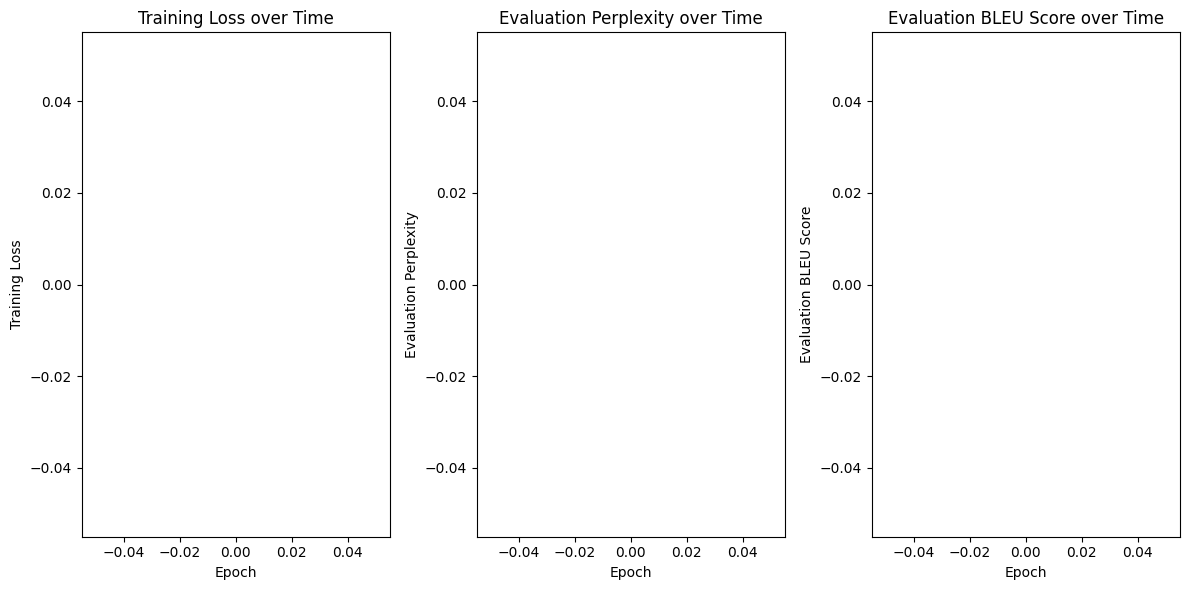

In [24]:
# Plotting logic | self composed

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Time')

plt.subplot(1, 3, 2)
plt.plot(epochs, eval_ppls)
plt.xlabel('Epoch')
plt.ylabel('Evaluation Perplexity')
plt.title('Evaluation Perplexity over Time')

plt.subplot(1, 3, 3)
plt.plot(epochs, eval_bleus)
plt.xlabel('Epoch')
plt.ylabel('Evaluation BLEU Score')
plt.title('Evaluation BLEU Score over Time')

plt.tight_layout()
plt.show()


In [25]:
print(train_losses)

[]


### Testing the translations

In [24]:
model = torch.load('/content/drive/MyDrive/syntax_swap_modelv2.pt', map_location=torch.device('cuda'))
tokenizer = torch.load('/content/drive/MyDrive/syntax_swap_tokenizerv2.pt', map_location = torch.device('cuda'))

In [25]:
!pip install pyter3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import pyter

In [ ]:
if do_test:
    print("Test file: {} & {}".format(test_source_filename, test_target_filename))
    eval_examples = read_examples(test_source_filename, test_target_filename)
    eval_features = convert_examples_to_features(eval_examples, tokenizer,stage='test')
    eval_data = TextDataset(eval_features, max_source_length) 

    # Calculate bleu
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size,num_workers=4)

    model.eval() 
    p=[]
    for batch in tqdm(eval_dataloader,total=len(eval_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        source_ids,source_mask,position_idx,att_mask,target_ids,target_mask = batch                    
        with torch.no_grad():
            preds = model(source_ids,source_mask,position_idx,att_mask)  
            for pred in preds:
                t=pred[0].cpu().numpy()
                t=list(t)
                if 0 in t:
                    t=t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                p.append(text)
    model.train()
    predictions=[]
    accs=[]
    with open(os.path.join(output_dir,"test_predicted.output"),'w') as f, open(os.path.join(output_dir,"test_true.gold"),'w') as f1:
        for ref,gold in zip(p,eval_examples):
            predictions.append(ref)
            f.write(ref+'\n')
            f1.write(gold.target+'\n')    
            accs.append(ref==gold.target)
    dev_bleu=round(_bleu(os.path.join(output_dir, "test_true.gold"), 
                            os.path.join(output_dir, "test_predicted.output")),2)
    print("  %s = %s "%("bleu-4",str(dev_bleu)))
    print("  %s = %s "%("xMatch",str(round(np.mean(accs)*100,4))))
    print("  "+"*"*20)  

   

Test file: /content/drive/MyDrive/Colab_Notebooks/snippets-programs-large-java-js/test-snippets_programs.java & /content/drive/MyDrive/Colab_Notebooks/snippets-programs-large-java-js/test-snippets_programs.js


100%|██████████| 7886/7886 [00:40<00:00, 196.56it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/658 [00:00<?, ?it/s]<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.m

  bleu-4 = 79.06 
  xMatch = 56.1755 
  ********************


In [ ]:
 # Translation edit rate (self-composed) | Moved to here becuase it takes some time
ter_scores = []
for pred, gold in zip(predictions, eval_examples):
  pred_tokens = pred.split()
  gold_tokens = gold.target.split()
  ter = pyter.ter(pred_tokens, gold_tokens)
  ter_scores.append(ter)

avg_ter = np.mean(ter_scores)
ter_percent = avg_ter * 100
print("  %s = %.2f%% " % ("TER", round(ter_percent, 2)))

In [ ]:
torch.save(model, "/content/drive/MyDrive/gcodebert_java-js_smallmodel1.pt")

In [ ]:
trainned_model = '/content/drive/MyDrive/IIT/Final Year/Final Year Project/code/SyntaxSwap_model/ml_model/graphcodebert/model3/complete_modelv4.pt'
trainned_model2 = '/content/drive/MyDrive/gcodebert_java-js_model2.pt'
trainned_model3 = '/content/drive/MyDrive/gcodebert_java-js_model3.pt'
trainned_model4 = '/content/drive/MyDrive/complete_modelv5.pt'

import torch
from transformers import RobertaTokenizer
# model = torch.load(trainned_model4, map_location=torch.device('cuda'))
# tokenizer = RobertaTokenizer.from_pretrained('microsoft/graphcodebert-base')

model = torch.load('/content/drive/MyDrive/syntax_swap_modelv2.pt', map_location=torch.device('cuda'))
tokenizer = torch.load('/content/drive/MyDrive/syntax_swap_tokenizerv2.pt', map_location = torch.device('cuda'))

In [ ]:
model.eval()

# import javalang
java_code = """
ArrayList < Integer > al = new ArrayList < > ( ) ;
if (al.length > 4) {
  System.out.println("greater than 4")
}
"""


In [ ]:
class Example(object):
    """A single training/test example."""
    def __init__(self,source, lang):
        self.source = source
        self.lang = lang

In [ ]:
example = Example(source=java_code.strip(), lang='java')
examples = []
examples.append(example)

In [ ]:
#load parsers
# parsers={}        
# for lang in dfg_function:
#     print("lang",lang)
#     LANGUAGE = Language('build_parser/my-languages.so', lang)
#     parser = Parser()
#     parser.set_language(LANGUAGE) 
#     parser = [parser,dfg_function[lang]]    
#     parsers[lang]= parser
    
print("Parsers :",parsers)
code_tokens, dfg=extract_dataflow(example.source, parsers['java'], 'java')
code_tokens=[tokenizer.tokenize('@ '+x)[1:] if idx!=0 else tokenizer.tokenize(x) for idx,x in enumerate(code_tokens)]

Parsers : {'java': [<tree_sitter.Parser object at 0x7f656bdd77d0>, <function DFG_java at 0x7f664a15dee0>], 'javascript': [<tree_sitter.Parser object at 0x7f656bdd7750>, <function DFG_javascript at 0x7f656bd98790>]}


In [ ]:
device = torch.device('cuda')

In [ ]:
# eval_examples = read_examples(file)
eval_features = convert_examples_to_features(examples, tokenizer,stage='test')
eval_data = TextDataset(eval_features, max_source_length) 

# Calculate bleu
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size,num_workers=4)

model.eval() 
p=[]
for batch in tqdm(eval_dataloader,total=len(eval_dataloader)):
    batch = tuple(t.to(device) for t in batch)
    source_ids,source_mask,position_idx,att_mask,target_ids,target_mask = batch                    
    with torch.no_grad():
        preds = model(source_ids,source_mask,position_idx,att_mask) 
        for pred in preds:
            t=pred[0].cpu().numpy()
            t=list(t)
            print(t)
            if 0 in t:
                t=t[:t.index(0)]
            text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
            print(text)
            p.append(text)

  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-15-5cd716aefcf6>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attn_mask=np.zeros((self.max_source_length,self.max_source_length),dtype=np.bool)
100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

[2716, 1076, 5457, 646, 27779, 25606, 114, 36, 1076, 479, 5933, 8061, 204, 4839, 25522, 3780, 479, 3116, 36, 22, 22, 4839, 25606, 35524, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
let al = [ ] ; if ( al . length > 4 ) { document . write ( " " ) ; }


In [ ]:
p

['let al = [ ] ; if ( al . length > 4 ) { document . write ( " " ) ; }']